In [2]:
# Environment settings
import scanpy as sc
import os
import numpy as np
import pandas as pd
import pickle
import plasticity_simlib as psl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
import utils_AT as util
"""
------------------------------------------------------------------------------
    Healthy cell                                Plastic cell                           
------------------------------------------------------------------------------
NEW_yang_GASTRIC_secretoryCell.h5ad         NEW_yang_HP_scrtrCell.h5ad 
NEW_yang_PrEMT_scrtrCell.h5ad               NEW_yang_HP_scrtrCell.h5ad 
NEW_yang_PrEMT_glndEpthCell.h5ad            NEW_yang_HP_glndEpthCell.h5ad
NEW_yang_Mesen2_cardiacCell.h5ad            NEW_yang_Mesen2Met_cardiacCell.h5ad
NEW_yang_Mesen2_epthCell.h5ad               NEW_yang_Mesen2Met_epthCell.h5ad

"""

""""  ###### VARIABLES ########  """
non_plastic_cell_cluster = 'NEW_yang_GASTRIC_secretoryCell.h5ad'  # NON-PLASTIC cell cluster name
plastic_cell_cluster = 'NEW_yang_HP_scrtrCell.h5ad'         # PLASTIC cell cluster name
main_dir = '../data/KPTracer-Data_divided/h5ad_filesWLineage/'
""""  ###### VARIABLES ########  """

NP_h5ad_data_path = main_dir + non_plastic_cell_cluster
NP_character_matrix_path = (main_dir + non_plastic_cell_cluster.split('.')[0]+'_character_matrix.pkl')
P_h5ad_data_path = main_dir + plastic_cell_cluster
P_character_matrix_path = (main_dir + plastic_cell_cluster.split('.')[0]+'_character_matrix.pkl')

# read the data and character matrix
NP_adams = sc.read(NP_h5ad_data_path)
with open(NP_character_matrix_path, 'rb') as file:
    NP_character_matrix = pickle.load(file)
P_adams = sc.read(P_h5ad_data_path)
with open(P_character_matrix_path, 'rb') as file:
    P_character_matrix = pickle.load(file)

In [3]:
# Compute the pairwise PHENOTYPIC distances between cells in the character matrix
NP_tree_dm = pairwise_distances(NP_character_matrix.values, metric=psl.modified_hamming_distance, force_all_finite=False)
NP_tree_dm = pd.DataFrame(NP_tree_dm, index=NP_character_matrix.index, columns=NP_character_matrix.index)
np.fill_diagonal(NP_tree_dm.values, np.nan) 

P_tree_dm = pairwise_distances(P_character_matrix.values, metric=psl.modified_hamming_distance, force_all_finite=False)
P_tree_dm = pd.DataFrame(P_tree_dm, index=P_character_matrix.index, columns=P_character_matrix.index)
np.fill_diagonal(P_tree_dm.values, np.nan)    # Replace values in the diagonal with np.nan

In [4]:
# Compute the pairwise PHYLOGENETIC distances between cells
NP_pheno_dm = pairwise_distances(NP_adams.X, metric='euclidean')
NP_pheno_dm = pd.DataFrame(NP_pheno_dm, index=NP_adams.obs_names, columns= NP_adams.obs_names)
np.fill_diagonal(NP_pheno_dm.values, np.nan)

P_pheno_dm = pairwise_distances(P_adams.X, metric='euclidean')
P_pheno_dm = pd.DataFrame(P_pheno_dm, index=P_adams.obs_names, columns= P_adams.obs_names)
np.fill_diagonal(P_pheno_dm.values, np.nan)


In [33]:
# overlap
# overlaps = psl.get_overlaps(tree_dm, pheno_dm, radii=np.arange(1, len(tree_dm.columns), 10))
# overlaps = psl.get_overlaps(tree_dm, pheno_dm, radii=np.arange(1, 50, 10))
# overlaps = psl.get_overlaps(tree_dm, pheno_dm, np.array_split(np.arange(tree_dm.shape[0]), 50))
#overlaps.to_csv(os.path.join(data_dir, 'overlaps.csv'))


  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
file_dir = "../files/overlap_"
np_overlap_file = file_dir+util.create_image_name(name=non_plastic_cell_cluster.split('.')[0], format='.csv')
p_overlap_file = file_dir+util.create_image_name(name=plastic_cell_cluster.split('.')[0], format='.csv')

In [12]:
NP_radii = [len(_) for _ in np.array_split(np.arange(NP_tree_dm.shape[0]), 50)]
NP_overlaps = psl.get_overlaps(NP_tree_dm, NP_pheno_dm, np.cumsum(NP_radii))
NP_overlaps.to_csv(np_overlap_file)
P_radii = [len(_) for _ in np.array_split(np.arange(P_tree_dm.shape[0]), 50)]
P_overlaps = psl.get_overlaps(P_tree_dm, P_pheno_dm, np.cumsum(P_radii))
P_overlaps.to_csv(p_overlap_file)

KeyboardInterrupt: 

In [ ]:
NP_gini_index = psl.get_gini_index(NP_overlaps)
NP_gini_index['Plasticity'] = 'Non-Plastic'
P_gini_index = psl.get_gini_index(P_overlaps)
P_gini_index['Plasticity'] = 'Plastic'

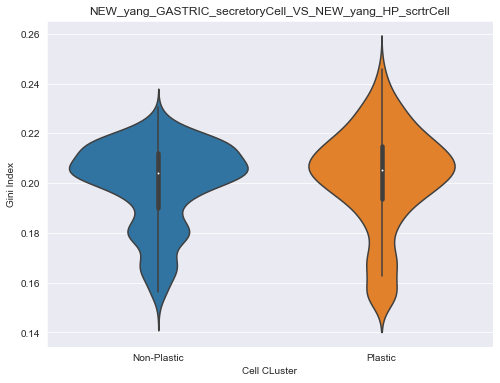

In [91]:
gini_index = pd.concat([NP_gini_index, P_gini_index], axis=0)
plt.figure(figsize=(8,6))
sns.violinplot(x='Plasticity', y='Gini Index', data=gini_index)
plt.xlabel('Cell CLuster')
plt.ylabel('Gini Index')
title = non_plastic_cell_cluster.split('.')[0]+'_VS_'+plastic_cell_cluster.split('.')[0]
plt.title(title)

plt.savefig(('figures/'+util.create_image_name('GI_'+title,format='.jpg')), bbox_inches='tight', dpi=150)
plt.show()
print()

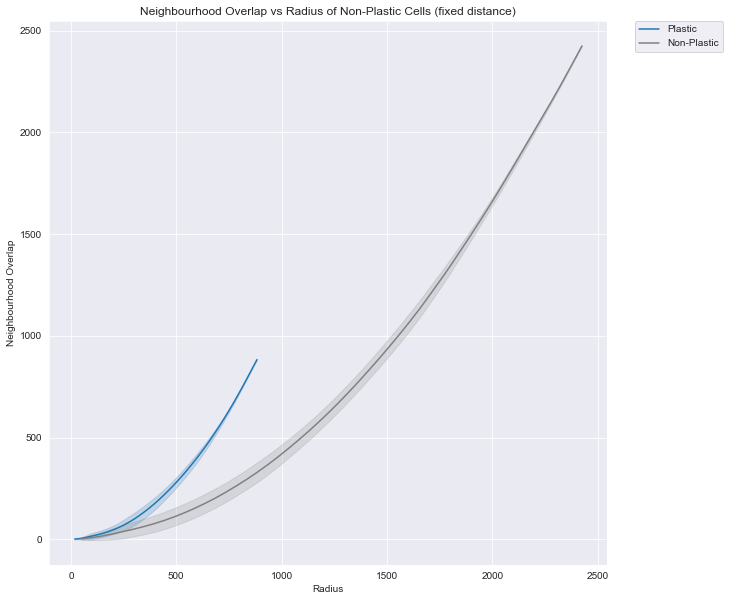

In [92]:
plt.figure(figsize=(10,10))
sns.lineplot(x='variable', y='value', data=P_overlaps.melt(), errorbar='sd', label='Plastic')
sns.lineplot(x='variable', y='value', data=NP_overlaps.melt(), errorbar='sd', label='Non-Plastic', color='grey')
plt.xlabel('Radius')
plt.ylabel('Neighbourhood Overlap')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Neighbourhood Overlap vs Radius of Non-Plastic Cells (fixed distance)')
plt.savefig(('figures/'+util.create_image_name('neighborOverlap_'+title, format='.jpg')), bbox_inches='tight', dpi=150)
plt.show()